# Chapter 11: The Central Role of the Propensity Score in Observational Studies for Causal Effects

In [1]:
from joblib import Parallel, delayed

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from causalinference import CausalModel
font = {'family' : 'IBM Plex Sans Condensed',
               'weight' : 'normal',
               'size'   : 10}
plt.rc('font', **font)
plt.rcParams['figure.figsize'] = (6, 6)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

np.random.seed(42)
%load_ext autoreload
%autoreload 1

%load_ext watermark
%watermark --iversions



pandas           : 1.5.2
seaborn          : 0.12.2
matplotlib       : 3.6.3
matplotlib_inline: 0.1.6
numpy            : 1.23.5
statsmodels      : 0.13.5



[CausalInference](https://github.com/apoorvalal/CausalinferencePy) library for Estimators discussed in Imbens and Rubin (2015)

## regression

In [2]:
nhanes_bmi = pd.read_csv('nhanes_bmi.csv')
nhanes_bmi.head()
z, y, X = nhanes_bmi.School_meal.values, nhanes_bmi.BMI.values, nhanes_bmi.iloc[:, 3:].values


In [3]:
def regEst(y, z, X):
    m0 = sm.OLS(y, sm.add_constant(z)).fit(vcov = 'HC2')
    m1 = sm.OLS(y, np.c_[sm.add_constant(z), X]).fit(vcov = 'HC2')
    m2 = sm.OLS(y,
                np.c_[sm.add_constant(z),
                      X - X.mean(axis = 0),
                      z.reshape(-1, 1) * (X - X.mean(axis = 0))]
                ).fit(vcov = 'HC2')
    res = np.c_[
        np.r_[m0.params[1], m0.bse[1]],
        np.r_[m1.params[1], m1.bse[1]],
        np.r_[m2.params[1], m2.bse[1]]
    ]
    return pd.DataFrame(res, index = ['est', 'se'], columns = ['naive', 'fisher', 'lin'])


In [4]:
regEst(y, z, X)


,naive,fisher,lin
est,0.533904,0.061248,-0.016954
se,0.225701,0.220883,0.223635


## propensity score stratification

In [5]:
psmod = sm.Logit(z, X).fit()
pscores = psmod.predict(X)


Optimization terminated successfully.
         Current function value: 0.542402
         Iterations 6


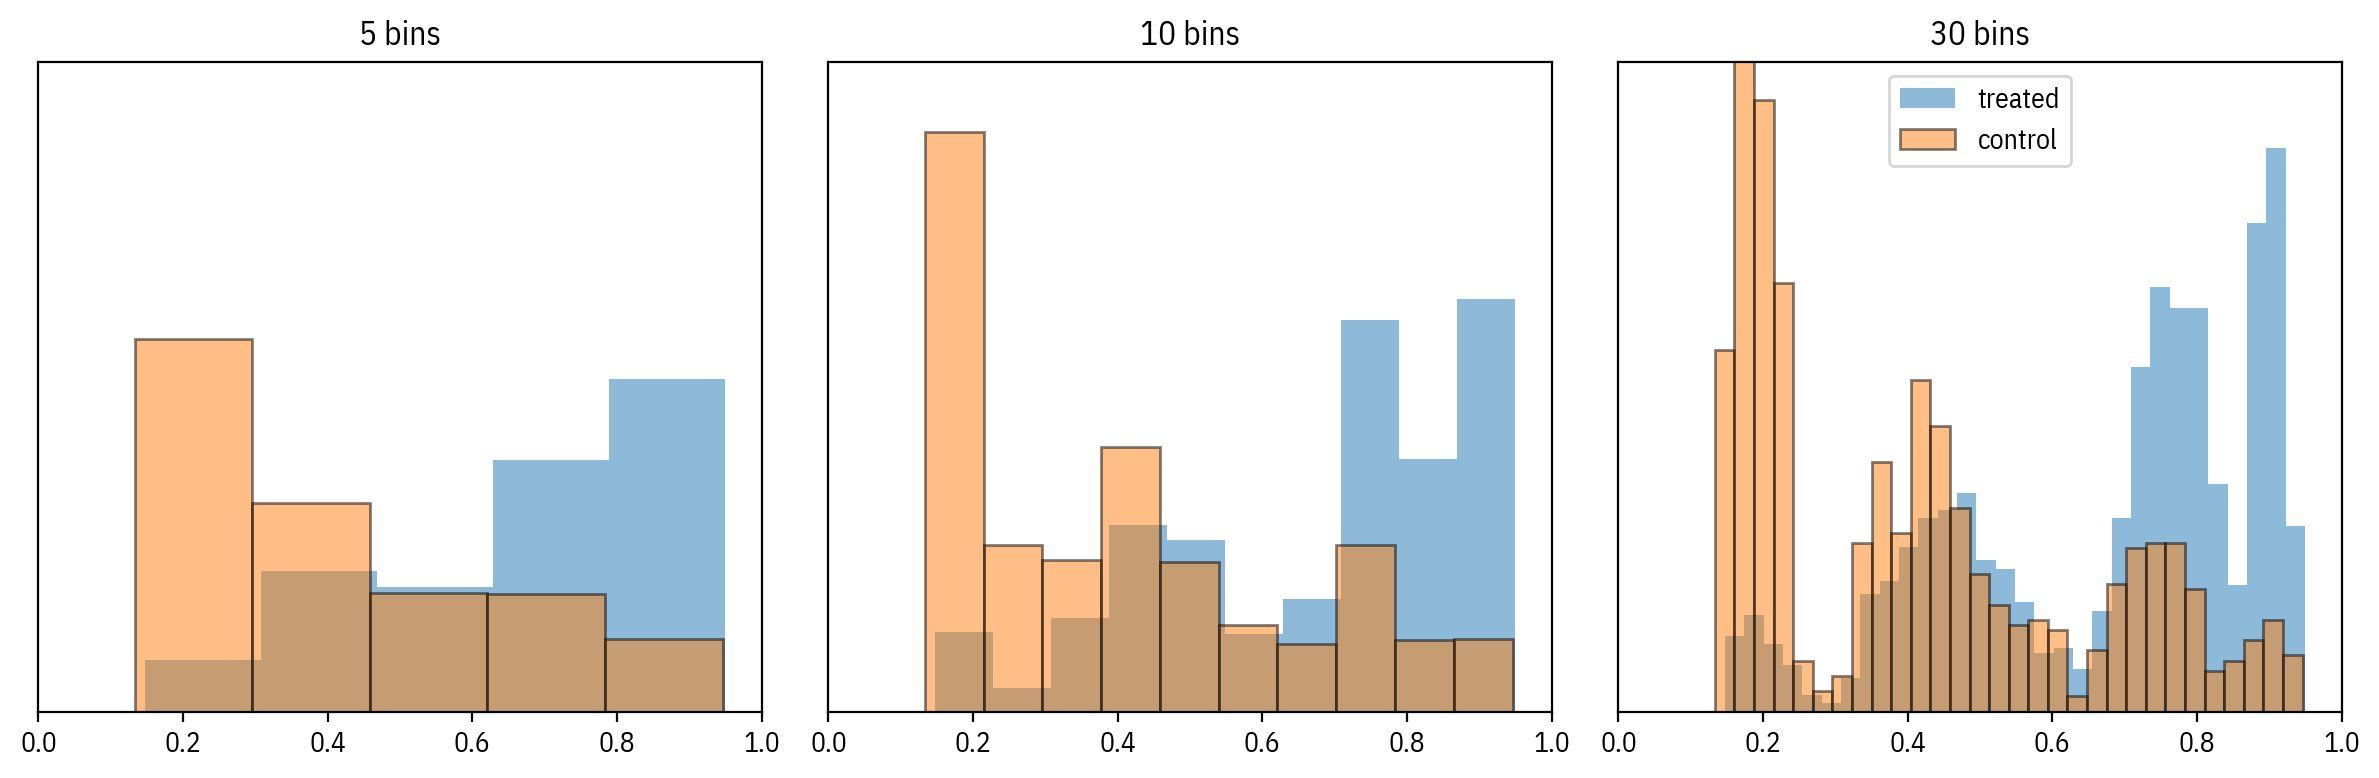

In [6]:
f, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].hist(pscores[z == 1], bins=5, alpha=0.5, density=True)
ax[0].hist(pscores[z == 0], bins=5, alpha=0.5, density=True, edgecolor="black")
ax[1].hist(pscores[z == 1], bins=10, alpha=0.5, density=True)
ax[1].hist(pscores[z == 0], bins=10, alpha=0.5, density=True, edgecolor="black")
ax[2].hist(pscores[z == 1], bins=30, alpha=0.5, density=True, label="treated")
ax[2].hist(
    pscores[z == 0],
    bins=30,
    alpha=0.5,
    density=True,
    label="control",
    edgecolor="black",
)
ax[2].legend()

# Hide the y-axis
ax[0].set_ylim(0, 4.5), ax[1].set_ylim(0, 4.5), ax[2].set_ylim(0, 4.5)
ax[0].set_xlim(0, 1), ax[1].set_xlim(0, 1), ax[2].set_xlim(0, 1)
ax[0].set_yticks([]), ax[1].set_yticks([]), ax[2].set_yticks([])
ax[0].set_yticklabels([]), ax[1].set_yticklabels([]), ax[2].set_yticklabels([])
ax[0].set_title("5 bins"), ax[1].set_title("10 bins"), ax[2].set_title("30 bins")
f.tight_layout()


In [7]:
m = CausalModel(y, z, X)
m.est_propensity()
m.cutoff = 0
res = []
for nn in [5, 10, 20, 50, 80]:
    m.blocks = nn
    m.stratify()
    m.est_via_blocking(adj = 0)
    ests = m.estimates['blocking']
    res.append(np.array([ests['ate'], ests['ate_se']]))

pd.DataFrame(np.c_[res].T, index = ['est', 'se'], columns = [5, 10, 20, 50, 80])


/home/alal/Desktop/code/00_causal/CausalinferencePy/causalinference/core/summary.py:102: RuntimeWarning: invalid value encountered in divide
  return (mean_t - mean_c) / np.sqrt((sd_c**2 + sd_t**2) / 2)
/home/alal/Desktop/code/00_causal/CausalinferencePy/causalinference/estimators/ols.py:21: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  olscoef = np.linalg.lstsq(Z, Y)[0]
/home/alal/Desktop/code/00_causal/CausalinferencePy/causalinference/core/summary.py:28: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._dict["Y_t_sd"] = np.sqrt(data["Y_t"].var(ddof=1))
/home/alal/anaconda3/envs/econometrics/lib/python3.9/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,5,10,20,50,80
est,-0.116096,-0.177604,-0.199688,-0.264742,-0.203770
se,0.281897,0.279457,0.272488,0.256721,0.244644


## weighting

In [8]:
m.reset()
m.est_propensity()
m.cutoff = 0
m.trim()
m.est_via_weighting(estimand = 'ate')
m.estimates['weighting']


{'ate': -1.516283776946952, 'ate_se': nan}

In [9]:
m.reset()
m.est_propensity()
m.cutoff = 0
m.trim()
m.est_via_weighting(estimand = 'ate', final_est = 'reg')
m.estimates['weighting']


/home/alal/Desktop/code/00_causal/CausalinferencePy/causalinference/estimators/weighting.py:28: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  wlscoef = np.linalg.lstsq(Z_w, Y_w)[0]


{'ate': -1.4490265174826407, 'ate_se': 0.5721131795463905}

In [10]:
m.reset()
m.est_propensity()
m.cutoff = 0.01
m.trim()
m.est_via_weighting(estimand = 'ate')
m.estimates['weighting']


{'ate': -1.516283776946952, 'ate_se': nan}

In [11]:
m.reset()
m.est_propensity()
m.cutoff = 0.01
m.trim()
m.est_via_weighting(estimand = 'ate', final_est = 'reg')
m.estimates['weighting']


{'ate': -1.4490265174826407, 'ate_se': 0.5721131795463905}

In [12]:
m.reset()
m.est_propensity()
m.cutoff = 0.05
m.trim()
m.est_via_weighting(estimand = 'ate')
m.estimates['weighting']


{'ate': -1.3034023808081816, 'ate_se': nan}

In [13]:
m.reset()
m.est_propensity()
m.cutoff = 0.05
m.trim()
m.est_via_weighting(estimand = 'ate', final_est = 'reg')
m.estimates['weighting']


{'ate': -1.1832759811240354, 'ate_se': 0.5331935984637113}

In [14]:
m.reset()
m.est_propensity()
m.cutoff = 0.1
m.trim()
m.est_via_weighting(estimand = 'ate')
m.estimates['weighting']


{'ate': -0.0859162644736214, 'ate_se': nan}

In [15]:
m.reset()
m.est_propensity()
m.cutoff = 0.1
m.trim()
m.est_via_weighting(estimand = 'ate', final_est = 'reg')
m.estimates['weighting']


{'ate': -0.27578024335036516, 'ate_se': 0.43133131699113925}